In [3]:
import os

# Замените на путь к вашей рабочей папке
new_working_directory = os.path.dirname(os.getcwd())

try:
    os.chdir(new_working_directory)
    print(f"Рабочая директория изменена на: {os.getcwd()}")
except OSError:
    print(f"Ошибка: Не удалось изменить рабочую директорию на {new_working_directory}")

Рабочая директория изменена на: /Users/user/Documents/university/Дипломы/Никита


In [4]:
from tqdm import tqdm

from typing import Iterable
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from utils.model import generate_sequence, save_model
from torchvision.transforms import v2

from utils.transform import reverse_transform_decorator
from utils.display import show_image_with_bboxes
from utils.iou import iou
from utils.system import delete_files_with_prefix
from models.simple_decoder import SimpleFaceDetector, info_string as model_info_string
from dataset_classes.vgg_face2_detector import VGGFace2DetectorDataset

In [5]:
device = 'cude' if torch.cuda.is_available() else 'cpu'

In [6]:
MODE = 'train' # 'train' | 'prod'
PATH_TO_SAVED_FILE = './best_models/best_simple_decoder_04-05_23:49_epoch_4.pt' # Путь к сохраненному файлу с параметрами


In [7]:
def is_load_from_saved():
    return PATH_TO_SAVED_FILE is not None

if is_load_from_saved():
    load_parameters = torch.load(PATH_TO_SAVED_FILE)

In [8]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((256, 256)),  # Измените размер под вашу модель
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def reverse_transform(image: torch.Tensor, new_image_size: Iterable):
    new_height, new_width = new_image_size
    
    fn = v2.Compose([
        v2.Normalize(mean=(-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), std=(1 / 0.5, 1 / 0.5, 1 / 0.5)),
        v2.Resize((new_height, new_width)),  # Возвращаем к исходному размеру
    ])
    
    return fn(image)


In [9]:
import os
import json


import torch
from PIL import Image

from torch.utils.data import Dataset
from torchvision.transforms import v2

from utils.transform import transform_bbox


class VGGFace2DetectorDataset(Dataset):
  transform_image_to_tensor = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
  ])
  
  def __init__(
    self, 
    images_path, 
    labels_path, 
    transform_image=None, 
    reverse_transform_image=None
  ):
    self.images_path = images_path
    self.labels_path = labels_path
    self.transform_image = transform_image
    self.reverse_transform_image = reverse_transform_image

    self.len_dataset = 0
    self.data_list = self._get_data_list(self.images_path)

    
  def _validate_image(self, image_path):
    label_path = self._get_annotation_path(image_path)
    
    return os.path.exists(label_path)
        
  def _get_data_list(self, images_path):
    data_list = []
    for path_dir, dir_list, file_list in os.walk(images_path):
      # if path_dir == images_path:
      #   continue

      for file_path in file_list:
        image_path = os.path.join(path_dir, file_path)
        
        if self._validate_image(image_path):
          data_list.append(image_path)
      
    return data_list
    
  
  def transform(self, image, bbox):
    if self.transform_image is not None:
      new_image = self.transform_image(image)
    else:
      new_image = self.transform_image_to_tensor(image)
      
    new_bbox = transform_bbox(
      bbox, 
      image.size[::-1],
      new_image.shape[1:],
    )
    
    return new_image, new_bbox
  
  def _get_annotation_path(self, image_path):
    relative_label_path = os.path.sep.join(image_path.split(os.path.sep)[-2:]).replace('.jpg', '.json')
    return os.path.join(self.labels_path, relative_label_path)
  
  def __getitem__(self, index):
    image_path = self.data_list[index]
    
    label_path = self._get_annotation_path(image_path)
    
    with open(label_path, 'r') as f:
      label = json.loads(f.read(), strict=False)

    original_bbox = label['annotations'][0]['bbox'] if label['annotations'] else [0,0,0,0]
    original_image = Image.open(image_path)
    confidence = 0 if original_bbox == [0,0,0,0] else 1
    
    new_image, new_bbox = self.transform(original_image, original_bbox)
    
    return new_image, new_bbox, torch.tensor([confidence], dtype=torch.float32), original_image.size[::-1], image_path, label_path
  
  def __len__(self):
    return len(self.data_list)

In [10]:
empty_dataset = VGGFace2DetectorDataset(
    './dataset/images/test/empty',
    './dataset/labels/test',
    transform,
    reverse_transform
)

In [12]:
model = SimpleFaceDetector().to(device)

if is_load_from_saved():
    model.load_state_dict(load_parameters['state_model'])


In [13]:
len(empty_dataset)

47533

164/47533


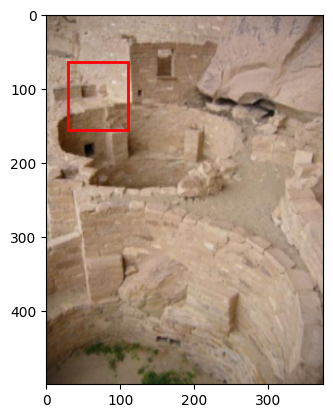

KeyboardInterrupt: 

In [14]:
count = 0
for image, bbox, confidence, original_image_size, image_path, label_path in empty_dataset:
    count += 1
    is_delete = 0 
    print(f'{count}/{len(empty_dataset)}')
    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи
    
    predict_bbox, predict_confidence = model.forward(data)
    predict_bbox = predict_bbox[0]
    predict_confidence = predict_confidence[0]
    
    if predict_confidence > 0.5:
        reverse_func = reverse_transform_decorator(
            reverse_transform, 
            original_image_size
        )
        
        original_image, predict_bbox = reverse_func(image, predict_bbox)
        show_image_with_bboxes(original_image, [predict_bbox])
        
        if is_delete:
            os.remove(image_path)
            os.remove(label_path)
    clear_output()